In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# Check if a GPU is available and set the device
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# dependencies
import os
import sys
import numpy as np
import torchvision.models as models
import torch
from torchvision import transforms
import numpy as np
from skimage import io, transform, color, metrics
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
import torchvision
import torch.nn as nn
from torch.nn import functional as F

In [5]:
def path_to_list(path):  
  image_names = []
  with open(path, 'r') as file:
      for line in file:
          # Remove any leading or trailing whitespace from the line
          line = line.strip()
          # Add the '.png' extension to the image name and append it to the list
          if(line!='' and line !=' '):
            image_names.append(line)
  # print(image_names[:10])
  return image_names


In [6]:
train_txt_path = '/content/drive/MyDrive/AIP_A2/q2/PascalVOC/trainval/train.txt'
validation_txt_path = '/content/drive/MyDrive/AIP_A2/q2/PascalVOC/trainval/val.txt'
images_path = '/content/drive/MyDrive/AIP_A2/q2/PascalVOC/trainval/Images'
annotations_path = '/content/drive/MyDrive/AIP_A2/q2/PascalVOC/trainval/Annotations'

In [8]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, image_path, annotations_path, image_names, transform=None):
        self.image_path = image_path
        self.annotations_path = annotations_path
        self.image_names = image_names
        self.transform = transform
    
    def __len__(self):
        return len(self.image_names)
    def rgb2mask(self,img):
      color2index = {
          (0,   0,   0)   : 0,   # background
          (128, 0,   0)   : 1,   # aeroplane
          (0,   128, 0)   : 2,   # bicycle
          (128, 128, 0)   : 3,   # bird
          (0,   0,   128) : 4,   # boat
          (128, 0,   128) : 5,   # bottle
          (0,   128, 128) : 6,   # bus
          (128, 128, 128) : 7,   # car
          (64,  0,   0)   : 8,   # cat
          (192, 0,   0)   : 9,   # chair
          (64,  128, 0)   : 10,  # cow
          (192, 128, 0)   : 11,  # dining table
          (64,  0,   128) : 12,  # dog
          (192, 0,   128) : 13,  # horse
          (64,  128, 128) : 14,  # motorbike
          (192, 128, 128) : 15,  # person
          (0,   64,  0)   : 16,  # potted plant
          (128, 64,  0)   : 17,  # sheep
          (0,   192, 0)   : 18,  # sofa
          (128, 192, 0)   : 19,  # train
          (0,   64,  128) : 20,  # tv/monitor
          }
      assert len(img.shape) == 3
      height, width, ch = img.shape
      assert ch == 3

      W = np.power(256, [[0],[1],[2]])

      img_id = img.dot(W).squeeze(-1) 
      values = np.unique(img_id)

      mask = np.zeros(img_id.shape)

      for i, c in enumerate(values):
          try:
              mask[img_id==c] = color2index[tuple(img[img_id==c][0])] 
          except:
              pass
      return mask
    
    def __getitem__(self, index):
        # get the name of the image at the given index
        image_name = self.image_names[index]
        
        # load the image from file
        image_image_name = image_name + '.jpg'
        annotations_image_name = image_name + '.png'
        final_image_path = os.path.join(self.image_path,image_image_name)
        final_annotations_path = os.path.join(self.annotations_path, annotations_image_name)

        image = io.imread(final_image_path)
        

        annotation = imageio.imread(final_annotations_path , pilmode='RGB')
        annotation = np.asarray(annotation)
        if self.transform:
            annotation = self.transform(annotation)

        annotation = annotation.numpy().transpose((1, 2, 0))
        annotation = annotation*255
        annotation = np.rint(annotation)
        annotation = self.rgb2mask(annotation)
        annotation = np.rint(annotation)
        annotation = (annotation).astype(int)
        
        # apply the transform (if any)
        if self.transform:
            image = self.transform(image)
            # annotation = self.transform(annotation)
        
        # return the image and its name
        return image, annotation

In [9]:
# Accuracy function
def pixelwise_accuracy(predicted_masks, gt_masks):
    acc = np.zeros(len(predicted_masks))
    for i in range(len(predicted_masks)):
      num_correct = np.sum(predicted_masks[i] == gt_masks[i])
      num_pixels = predicted_masks[i].size
      accuracy = num_correct / num_pixels
      acc[i] = accuracy
      
    return np.mean(acc)

In [18]:
# Mean IOU function
def mean_iou(predicted_masks, gt_masks,num_classes):
    total_iou = np.zeros(len(predicted_masks))

    for i in range(len(predicted_masks)):
      
      temp = predicted_masks[i]
      
      # Initialize variables to store the per-class intersection and union
      intersection = []
      union = []

      # Calculate the intersection and union for each class
      for c in range(num_classes):
          # Get binary masks for the current class in the predicted and ground truth masks
          pred_class = (predicted_masks[i] == c)
          gt_class = (gt_masks[i] == c)
          
          # Calculate the intersection and union of the binary masks
          temp_union = np.logical_or(pred_class, gt_class).sum()
          if(temp_union!=0):
            intersection.append(np.logical_and(pred_class, gt_class).sum())
            union.append(temp_union) 
          
      # Calculate the IoU for each class and the overall mean IoU
      iou_per_class = [i / j for i, j in zip(intersection, union)]
      
      total_iou[i] = sum(iou_per_class)/len(iou_per_class)
      
    return np.mean(total_iou)

In [19]:
def train_model(mobilenet,train_txt_path,images_path,annotations_path,num_epochs):
  num_classes = 21
  # mobilenet = torchvision.models.mobilenet_v2(pretrained=True)
  mobilenet = nn.Sequential(*list(mobilenet.children())[:-1])
  for param in mobilenet.parameters():
      param.requires_grad = False
  mobilenet.add_module('final_conv', nn.Conv2d(1280, num_classes, kernel_size=1))
  mobilenet.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes,kernel_size=64, padding=16, stride=32))
  

  # Define the loss function and optimizer:=

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(mobilenet.parameters())

  # Transform
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize((256,256)),
  ])

  image_names = path_to_list(train_txt_path)

  train_image_dataset = CustomDataset(images_path,annotations_path,image_names,transform)
  # train_masks_dataset = CustomDataset(annotations_path,train_annotations_names,transform)



  # Load and preprocess your dataset
  train_loader = DataLoader(
      dataset=train_image_dataset,
      batch_size=1,
      shuffle=True,
      num_workers=1
  )

  # num_epochs = 10

  # Loading model to device (or GPU)
  # mobilenet.to(device)

  # Train
  mobilenet.train()
  # Train the model on the given dataset
  for epoch in range(num_epochs):
      for images, labels in train_loader:
          # Forward pass
          outputs = mobilenet(images)
          
          loss = criterion(outputs, labels)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
  mobilenet.cpu()
  return mobilenet

In [20]:
def test_model(mobilenet,validation_txt_path,images_path,annotations_path):
  num_classes = 21
  mobilenet.eval()

  # Transform
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize((256,256)),
  ])

  # Load and preprocess the test dataset
  image_names = path_to_list(validation_txt_path)

  validation_dataset = CustomDataset(images_path,annotations_path,image_names,transform)
  # validation_masks_dataset = CustomDataset(images_path,annotations_path,image_names,transform)
  # Load and preprocess your dataset
  test_loader = DataLoader(
      dataset=validation_dataset,
      batch_size=1,
      shuffle=True,
      num_workers=1
  )


  predicted_masks = []
  gt_masks = []
  
  with torch.no_grad():
    for images, labels in test_loader:
        
        output = mobilenet(images)
        
        
        # Convert the predicted segmentation mask to an integer numpy array
        output = torch.argmax(output, dim=1).squeeze().cpu().numpy().astype(np.int32)

        labels = labels.squeeze()
        labels = labels.numpy()
        
        predicted_masks.append(output)
        gt_masks.append(labels)

  mobilenet.cpu()
  return pixelwise_accuracy(predicted_masks,gt_masks),mean_iou(predicted_masks, gt_masks,21)

In [21]:
mobilenet = torchvision.models.mobilenet_v2(pretrained=True)

mobilenet = train_model(mobilenet,train_txt_path,images_path,annotations_path,20)
acc,iou = test_model(mobilenet,validation_txt_path,images_path,annotations_path)
print("Accuracy: ",acc,"\nIOU: ",iou)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 1.3283
Epoch [2/20], Loss: 1.2715
Epoch [3/20], Loss: 1.4731
Epoch [4/20], Loss: 0.8784
Epoch [5/20], Loss: 1.2843
Epoch [6/20], Loss: 0.4626
Epoch [7/20], Loss: 1.1117
Epoch [8/20], Loss: 1.0285
Epoch [9/20], Loss: 1.2118
Epoch [10/20], Loss: 0.3471
Epoch [11/20], Loss: 1.3365
Epoch [12/20], Loss: 0.4614
Epoch [13/20], Loss: 1.8148
Epoch [14/20], Loss: 1.3314
Epoch [15/20], Loss: 0.6069
Epoch [16/20], Loss: 0.7333
Epoch [17/20], Loss: 0.2746
Epoch [18/20], Loss: 4.2741
Epoch [19/20], Loss: 1.3043
Epoch [20/20], Loss: 0.2145
Accuracy:  0.7575306780461414 
IOU:  0.2501428611419563


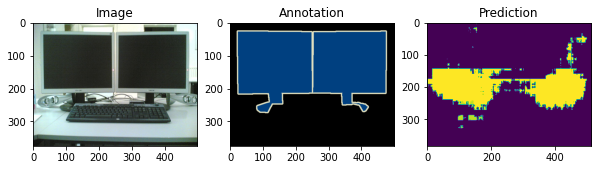

In [33]:
s = path_to_list(validation_txt_path)[2]
image_name = s + '.jpg'
annotation_name = s + '.png'
image = io.imread(os.path.join(images_path,image_name))
annotation = imageio.imread(os.path.join(annotations_path,annotation_name), pilmode='RGB')
annotation = np.asarray(annotation)


fig, ax = plt.subplots(1, 3, figsize=(10, 5))

# Display the image
ax[0].imshow(image)
ax[0].set_title('Image')

# Display the annotation
ax[1].imshow(annotation)
ax[1].set_title('Annotation')

# Display the annotation
composed_transform = transforms.Compose([
    transforms.ToTensor(),
])

image = composed_transform(image)
image = image.unsqueeze(0)
prediction = mobilenet(image)
prediction = torch.argmax(prediction, dim=1).squeeze().cpu().numpy().astype(np.int32)
# Display the Prediction
ax[2].imshow(prediction)
ax[2].set_title('Prediction')

plt.show()